warning: to successfully run this notebook, prepare at least 32GB memory and 2~3 hours running time.

In [1]:
import numpy as np
import scipy.signal
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.pixel_grid import PixelGrid
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

np.random.seed(41)

##### Import the data images

In [2]:
psf_filename = 'SPT0311-58_cont_natural_selfcalp1.psf.fits'
image_filename = 'SPT0311-58_cont_natural_selfcalp1_dirty.image.fits'
pb_filename = 'SPT0311-58_cont_natural_selfcalp1.pb.fits'

In [3]:
Length = 450
x_cut_start = 1165
y_cut_start = 1275

dirty_image = pyfits.getdata(image_filename)
dirty_image = dirty_image[0][0]
dirty_image_cut = dirty_image[y_cut_start:y_cut_start+Length:1,x_cut_start:x_cut_start+Length:1]

pb = pyfits.getdata(pb_filename)
pb_cut = pb[0][0][y_cut_start:y_cut_start+Length:1,x_cut_start:x_cut_start+Length:1]

psf = pyfits.getdata(psf_filename)
psf_cut = psf[0][0][1500-450:1500+451:1,1500-450:1500+451:1]

<ipython-input-4-c27bf21c4970>:8: RuntimeWarning: invalid value encountered in log10
  cr2 = r2.matshow(np.log10(psf_cut),origin='lower')


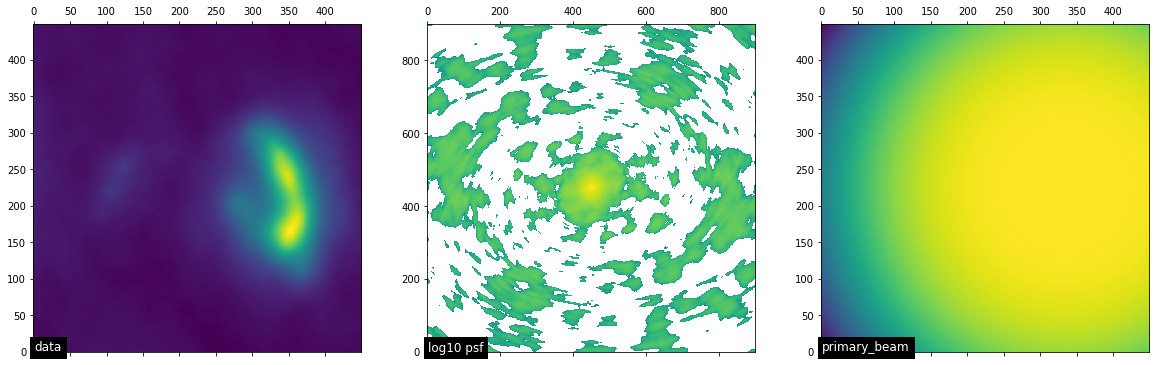

In [4]:
fig = plt.figure(figsize=(20,12))

r1 = fig.add_subplot(131)
cr1 = r1.matshow(dirty_image_cut,origin='lower')
r1.text(1, 1, 'data', fontsize=12,c='w',backgroundcolor='black')

r2 = fig.add_subplot(132)
cr2 = r2.matshow(np.log10(psf_cut),origin='lower')
r2.text(1, 1, 'log10 psf', fontsize=12,c='w',backgroundcolor='black')

r3 = fig.add_subplot(133)
cr3 = r3.matshow(pb_cut,origin='lower')
r3.text(1, 1, 'primary_beam', fontsize=12,c='w',backgroundcolor='black')

plt.show()

##### Define the data_class, psf_class, lens_model_class and source_pixel_grid_class of lenstronomy

In [5]:
# data specifics
background_rms = 7.48e-6  #  background noise per pixel (Gaussian rms value)
exp_time = np.inf  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 450  #  cutout pixel size
deltaPix = 0.008  #  pixel size in arcsec (area per pixel = deltaPix**2)

# define the data class
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
kwargs_data['antenna_primary_beam'] = pb_cut  # put primary beam here
kwargs_data['likelihood_method'] = 'interferometry_natwt'
kwargs_data['image_data'] = dirty_image_cut
kwargs_data['ra_at_xy_0']=-(1500-1165)*deltaPix # x coordinate at the (0,0) pixel
kwargs_data['dec_at_xy_0']=-(1500-1275)*deltaPix # y coordinate at the (0,0) pixel
data_class = ImageData(**kwargs_data)

In [6]:
# define the psf class
kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix,
              'kernel_point_source': psf_cut, 'kernel_point_source_normalisation': False}
psf_class = PSF(**kwargs_psf)

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\lenstronomy\Data\psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


In [7]:
# define the lens model class

kwargs_SIE_Caustics_Calibrated = {'theta_E': 0.331,
  'gamma': 2.0,
  'e1': 0.323,
  'e2': -0.322,
  'center_x': -0.368,
  'center_y': -0.142}

kwargs_SIE_fitting = {'theta_E': 0.33178176767176526,
   'gamma': 2.0,
   'e1': 0.3367177648186059,
   'e2': -0.43799608752954816,
   'center_x': -0.3732630056628361,
   'center_y': -0.13944499261050985}

lens_model_list = ['EPL']
kwargs_lens = [kwargs_SIE_Caustics_Calibrated] # Change the lens model to get the different reconstruction
lens_model_class = LensModel(lens_model_list=lens_model_list)

In [8]:
# define the source pixel grid class
# Here this source region only covers the west galaxies

source_pixel_width = deltaPix
source_pixel_num_x_axis = 120
source_pixel_num_y_axis = 200
ra_at_xy_0_source = -(1500-1165-265)*deltaPix
dec_at_xy_0_source = -(1500-1275-110)*deltaPix

transform_pix2angle = source_pixel_width * np.identity(2)
source_pixel_grid_class = PixelGrid(nx = source_pixel_num_x_axis, ny = source_pixel_num_y_axis, 
                                    transform_pix2angle = transform_pix2angle, 
                                    ra_at_xy_0 = ra_at_xy_0_source, dec_at_xy_0 = dec_at_xy_0_source)

##### Pixelated source reconstruction

In [9]:
# Define the PixelatedSourceReconstruction class
from lenstronomy.ImSim.SourceReconstruction.pixelated_source_reconstruction import PixelatedSourceReconstruction
PSR = PixelatedSourceReconstruction(data_class, psf_class, lens_model_class, source_pixel_grid_class)

In [49]:
# Construct the M and b
# It should take less than one hour
M_pixel, b_pixel = PSR.generate_M_b(kwargs_lens, verbose=True, show_progress=True)

number of source pixels: 24000 (x axis: 120 pixels;  y axis: 200 pixels)
likelihood method: interferometry_natwt
Step 1: Lensing the source pixels


Running (iteration times vary):   0%|          | 1/24000 [00:00<57:23,  6.97it/s]

Step 1: Finished!
Step 2: Compute the matrix M and vector b (including the convolution step)


Running (iteration times vary): 100%|██████████| 24000/24000 [33:33<00:00, 11.92it/s] 


Step 2: Finished!


In [50]:
# Generate the regularization matrix
from lenstronomy.ImSim.SourceReconstruction.regularization_matrix_pixel import pixelated_regularization_matrix

In [51]:
U_pixel = pixelated_regularization_matrix(120, 200, 'gradient')

In [52]:
# Solve the best regularization strength.

from lenstronomy.ImSim.SourceReconstruction.solve_regularization_strength import d_log_evi_d_lambda
from lenstronomy.ImSim.SourceReconstruction.solve_regularization_strength import solve_optimal_lambda

In [54]:
# Warning, this part is heavy because the matrices M and U are 24000 by 24000 in the size.
# It takes ~30GB memory to solve this optimal lambda in this case, 
# so I suggest to have at least 32GB memory for running this part.
# And it might take 1~2 hours to finish solving the optimal lambda.
# If the result is 0, it means the memory is not large enough to run this cell.

# For this case, the optimal regularization strength (lambda) is 
# between 40 / background_rms**2 and 60 / background_rms**2,
# which is found by testing different solving boundaries.
# So we finally choose [40, 60] / background_rms**2 as the lower and upper limits of lambda.
optimal_lambda = solve_optimal_lambda(d_log_evi_d_lambda, U_pixel, M_pixel, b_pixel, 
                                      40 / background_rms**2, 60 / background_rms**2, 
                                      tolerance = 1e-7,
                                      max_iterations = 10,
                                      check_initial_bounds = True)
print('optimal_lambda:', optimal_lambda)

optimal_lambda: 920353395596.8142


In [56]:
# To save memory, store lambda * U_pixel just in U_pixel
U_pixel *= 920353395596.8142

In [57]:
# This step requires large memory as well, 
# so prepare the same amount of memory as the "solve the best regularization strength" step.
source_pixel_amps = np.linalg.solve(M_pixel + U_pixel, b_pixel)

In [58]:
image_source_recon_west = np.zeros((numPix,numPix))
image_source_recon_west[110: 110+200, 265: 265+120] = source_pixel_amps.reshape(200,120)

In [60]:
image_lensed_recon_west = PSR.lens_an_image_by_rayshooting(kwargs_lens, source_pixel_amps.reshape(200,120))

In [65]:
image_lensed_convolved_west = scipy.signal.fftconvolve(pb_cut * image_lensed_recon_west, psf_cut,mode='same')

In [67]:
residual = (dirty_image_cut - image_lensed_convolved_west)

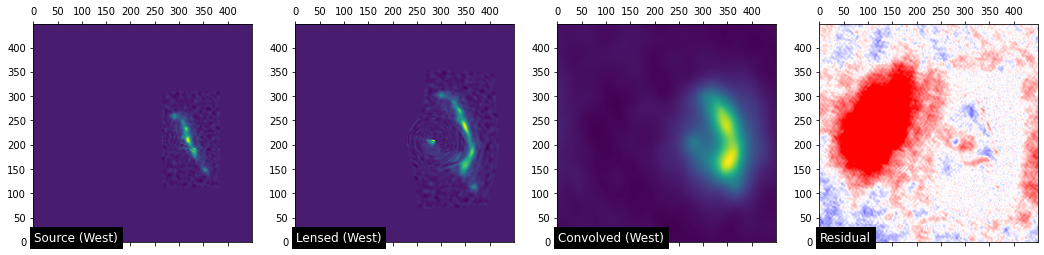

In [68]:
fig = plt.figure(figsize=(18,12))

r1 = fig.add_subplot(141)
cr1 = r1.matshow(image_source_recon_west,origin='lower')
r1.text(1, 1, 'Source (West)', fontsize=12,c='w',backgroundcolor='black')

r1 = fig.add_subplot(142)
cr1 = r1.matshow(image_lensed_recon_west,origin='lower')
r1.text(1, 1, 'Lensed (West)', fontsize=12,c='w',backgroundcolor='black')

r1 = fig.add_subplot(143)
cr1 = r1.matshow(image_lensed_convolved_west,origin='lower')
r1.text(1, 1, 'Convolved (West)', fontsize=12,c='w',backgroundcolor='black')

r1 = fig.add_subplot(144)
cr1 = r1.matshow(residual / background_rms,cmap='bwr',vmin=-6,vmax=6,origin='lower')
r1.text(1, 1, 'Residual', fontsize=12,c='w',backgroundcolor='black')

plt.show()

In [16]:
#np.save("west_pixel_e1_0323_e2_n0322.npy", image_source_recon_west)
#np.save("west_pixel_e1_0323_e2_n0322_lensed_convolved.npy", image_lensed_convolved_west)